МФТИ ФИВТ, Машинное обучение, Никита Волков

# Ранжирование

Дедлайн **24 ноября 23:59** для 399 группы и **25 ноября 23:59** для остальных групп.


Для выполнения задания потребуются следующие библиотеки: bs4, urllib, networkx. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install beautifulsoup4

sudo pip3 install urllib2

sudo pip3 install networkx

--------------

Прежде чем начать читать задание, просто посмотрите на картинку ранжирования котов :)

<img width=500 src="./resize.jpg">

# Тест

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

Пара запрос-документ. На некотором подмножестве таких пар заданы асессорские метки -- функция $y(q, d)$ которая чем выше, тем больше документ $d$ релевантен запросу $q$. $(q_1, d_1)$ сравнима с $(q_2, d_2)$ только если $q_1 = q_2$.

**2.** В чем преимущество метрики NDCG перед метрикой MAP?

В NDCG разрешается $\text{Im} y \subset \mathbb{R}$

**3.** Почему говорят, что все основные метрики качества дискретны?

Потому что их образ -- это конечное множество.

**4.** В чем преимущество факторизации в модели RankNet?

Стохастический градиентный спуск происходит по одной паре $(q, d)$, а не по двум (для этого произвели факторизацию $Q_{ij}$)

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

В SGD градиент функционала умножается на дельту метрики NDCG@k при замене симметричной замене $x_{i}$ на $x_{j}$ и наоборот.

**6.** Какое преобразование данных используется в модели RankSVM?

$(x_i, x_j) \mapsto (x_i - x_j, sign(y_i - y_j))$

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

Применим эргодическую теорему. Элементы $P^{2}$ положительны и они больше либо равны $p^2\frac{(n-2)}{(n-1)^2}$, поэтому можно применить эргодическую теорему и следовательно, $|p_{ij}^{(n)}-\pi_{j}| < \left(1 - p^2\frac{(n-2)}{(n-1)^2}\right)^{[n/2]}$.

**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

С точки зрения теории -- нет, ведь все равно при любом начальном $\Pi^{(0)}$, $P^n\Pi^{(0)}$ сходится к эргодическому распределению. С практической точки зрения -- может быть оправдано, например, если требуется выполнить лишь ограниченное число итераций метода. В этом случае нужно искать наилучшее начальное распределение.

# Задачи

(студенты 399 группы могут принести решение на листочках на семинар)

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

Мне кажется, что нет.

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

Вероятность попасть в произвольную вершину из (произвольной) фиксированной составляет хотя бы $\frac{p}{|V|}$ в силу определения матрицы перехода $P$. Поэтому для распределения вершин $\pi^{(n)}$ за $n$ шагов утверждение выполнено. А в силу эргодической теоремы выполнено и для предельного распределения. 

**3.** Пользователь браузера в дополнение к кликам по ссылкам может перейти по кнопке *Назад* и вернуться на предыдущую страницу? Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

Нет, ибо теперь распределение на вершинах зависит от истории посещений пользователя (он же может нажать на *Назад* несколько раз), а не только от текущего состояния. А это протеворечит однородности. Чтобы сделать этот процесс однородным, необходимо было бы поместить стек страницы пользователся с состояние в марковской цепи, но тогда множество состояний перестало бы быть конечным.

## Часть 1

In [1]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
import seaborn as sns

%matplotlib inline

Реализуйте вычисление весов PageRank power-методом.

Реализовать может быть удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [2]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links_set = set(links)
    links = np.array(links)
    if N is None:
        N = links.max() + 1
    
    prob_matrix = np.zeros(shape=(N, N))
    
    out_count = defaultdict(int)
    for u, v in links:
       out_count[u] += 1 
    
    for i in range(N):
        for j in range(N):
            if out_count[i] == 0:
                prob_matrix[i, j] = 1.0 / N
            else:
                prob_matrix[i, j] = 1.0 * damping_factor / N
                if (i, j) in links_set:
                    prob_matrix[i, j] += (1.0 - damping_factor) / out_count[i]
    
    return prob_matrix


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    prob_matrix = create_page_rank_markov_chain(links, 
                                                damping_factor=damping_factor,
                                                N=start_distribution.shape[1])
    start_distribution = np.array(start_distribution)
    
    trace = [start_distribution, start_distribution.dot(prob_matrix)]
    
    while np.sqrt(np.mean((trace[-1] - trace[-2]) ** 2)) > tolerance:
        trace.append(trace[-1].dot(prob_matrix))
    
    if return_trace:
        return np.array(trace[-1]).ravel(), np.array(trace)
    else:
        return np.array(trace[-1]).ravel()

Давайте посмотрим, как оно работает.
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [3]:
def random_graph(n, p):
    return [(i, j) for i, j in product(range(n), range(n)) if i != j and np.random.rand() <= p]

Теперь сгенерируем случайный граф и нарисуем его.

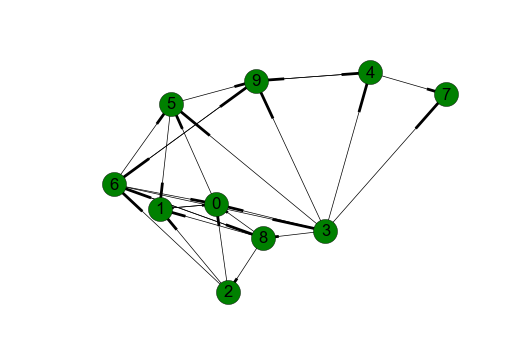

In [4]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_nodes_from(range(N))
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5, cmap='Greens', node_color='green')

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

[ 0.21408696  0.18393887  0.02875296  0.03582553  0.08096642  0.13188774
  0.09272924  0.0595476   0.04090081  0.13136388]


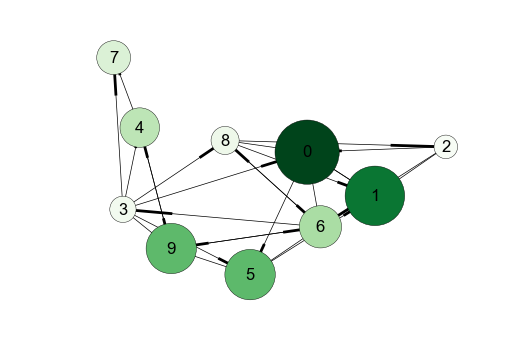

In [5]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 1e4
plt.axis('off')
print(pr_distribution)
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, node_color=pr_distribution, cmap='Greens')

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

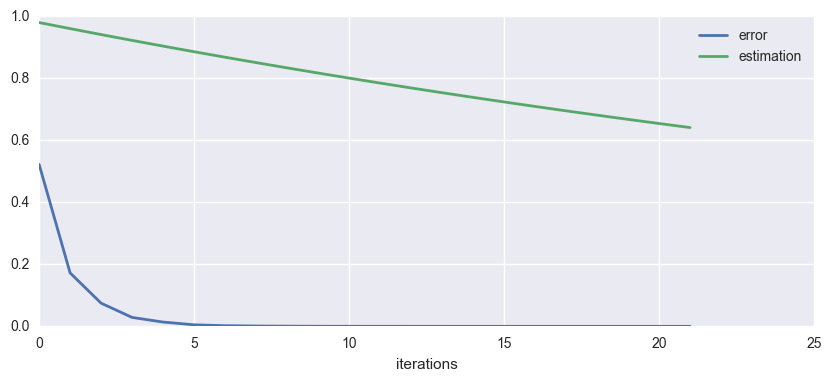

In [6]:
start_distribution = np.ones(shape=(1, N)) / N
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, (1.0 - p/N) ** (1+x), 
         lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

Как видим, верхняя оценка выполняется, но она не является точной.

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

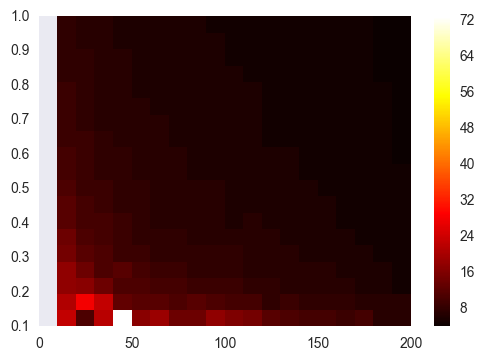

CPU times: user 12.8 s, sys: 67.2 ms, total: 12.8 s
Wall time: 13 s


In [7]:
%%time
from itertools import product
ps = np.linspace(0.1, 1.0, num=20)
Ns = np.linspace(10, 200, num=20, dtype=np.int)
S = np.zeros(shape=(Ns.shape + ps.shape))
for (i, N), (j, p) in product(enumerate(Ns), enumerate(ps)):
    edges = random_graph(N, p)
    start_distribution = np.ones((1, N)) / N
    pr_distribution, pr_trace = page_rank(edges, start_distribution, return_trace=True)
    
    S[i, j] = len(pr_trace)
plt.pcolor(*np.meshgrid(Ns, ps), S, cmap='hot')
plt.colorbar()
plt.show()

In [8]:
from scipy.stats import entropy, pearsonr

In [9]:
kls = []
lengths = []
N = 20
p = 0.1
edges = random_graph(N, p)
for i in range(5000):

    start_distribution = np.random.dirichlet(alpha=np.ones((N,)), size=(1,))

    pr_distribution, pr_trace = page_rank(edges, start_distribution, return_trace=True)
    kls.append(entropy(pr_distribution, start_distribution[0]))
    lengths.append(len(pr_trace))

0.19620462016968945

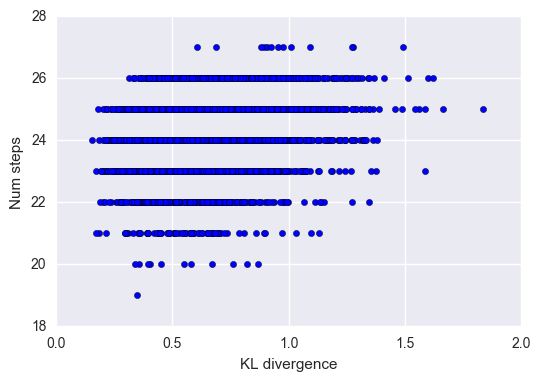

In [10]:
plt.scatter(kls, lengths)
plt.xlabel("KL divergence")
plt.ylabel("Num steps")
pearsonr(kls, lengths)[0]

Есть положительная корреляция между KL-дивергенцией и колиечеством шагов алгоритма. Форма облака точек похожа на верхнетреугольную.

Более того, в некотором смысле выполнено следующее утверждение:

1. Долго может работать алгоритм и при маленькой KL дивергенции, но
2. Если KL дивергенция большая, то алгоритм более склонен работать медленнее.

## Часть 2

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [11]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [15]:
urls = ['https://yandexdatafactory.com/']
site = get_site(urls[0])
links = []

N = 100
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Для получения дополнительных баллов проведите аналогичные исследования для больших сайтов. Так же вы можете провести исследования, не ограничиваясь загрузкой только одного сайта.

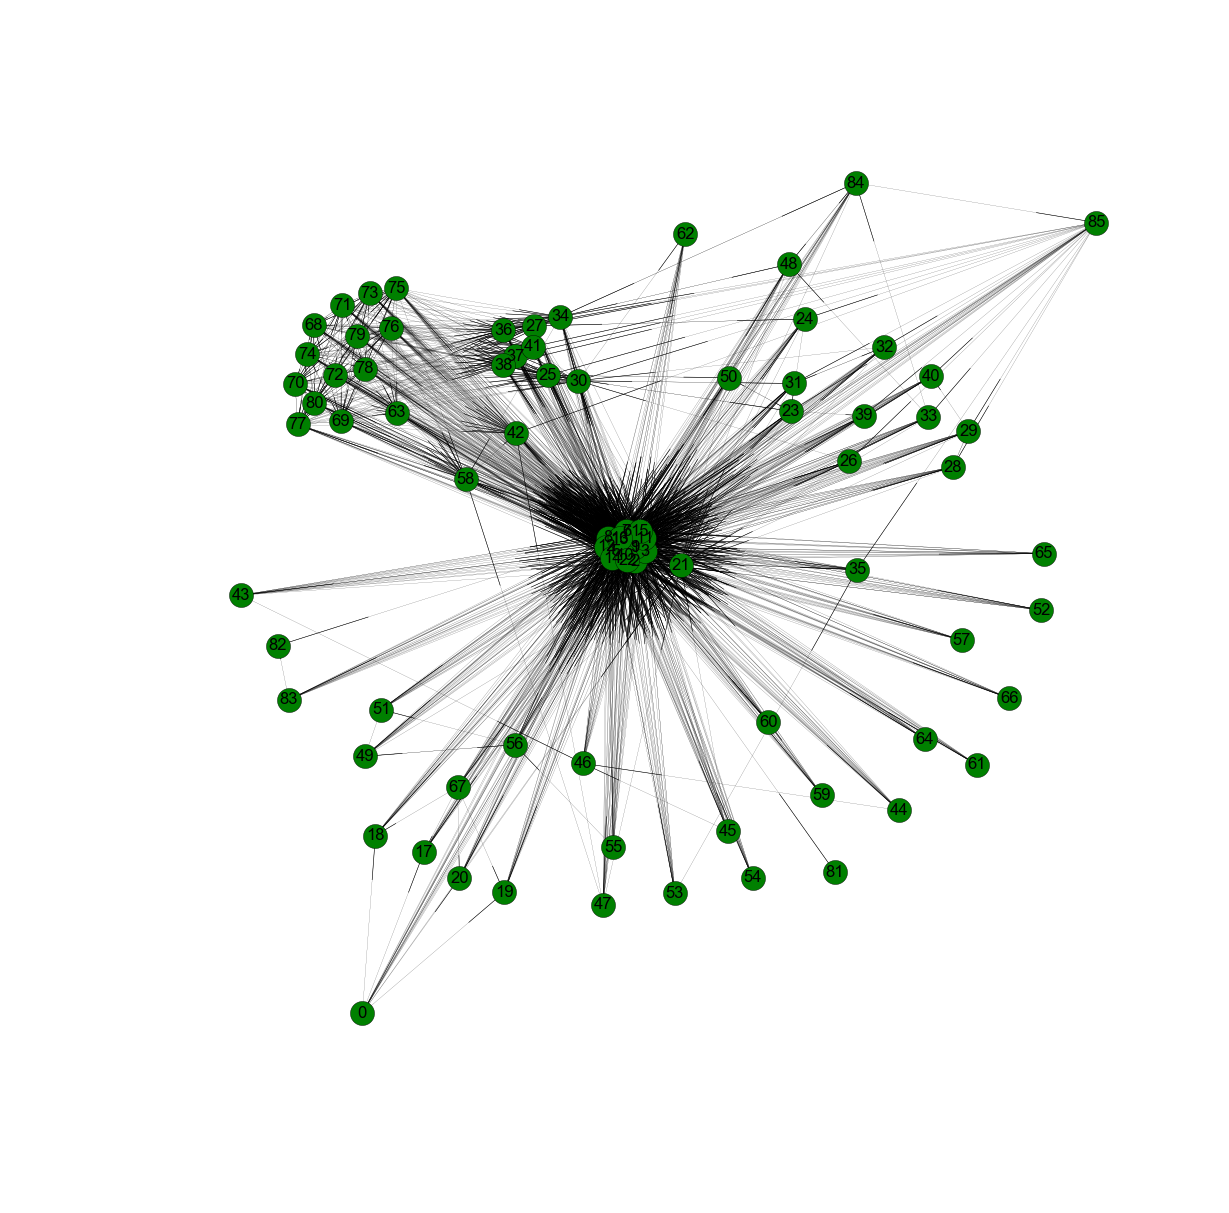

In [32]:
plt.figure(figsize=(15, 15))
N = np.array(links).max() + 1
G = networkx.DiGraph()
G.add_edges_from(links)
G.add_nodes_from(range(N))
plt.axis('off')
networkx.draw_networkx(G, width=0.1, node_color='green')

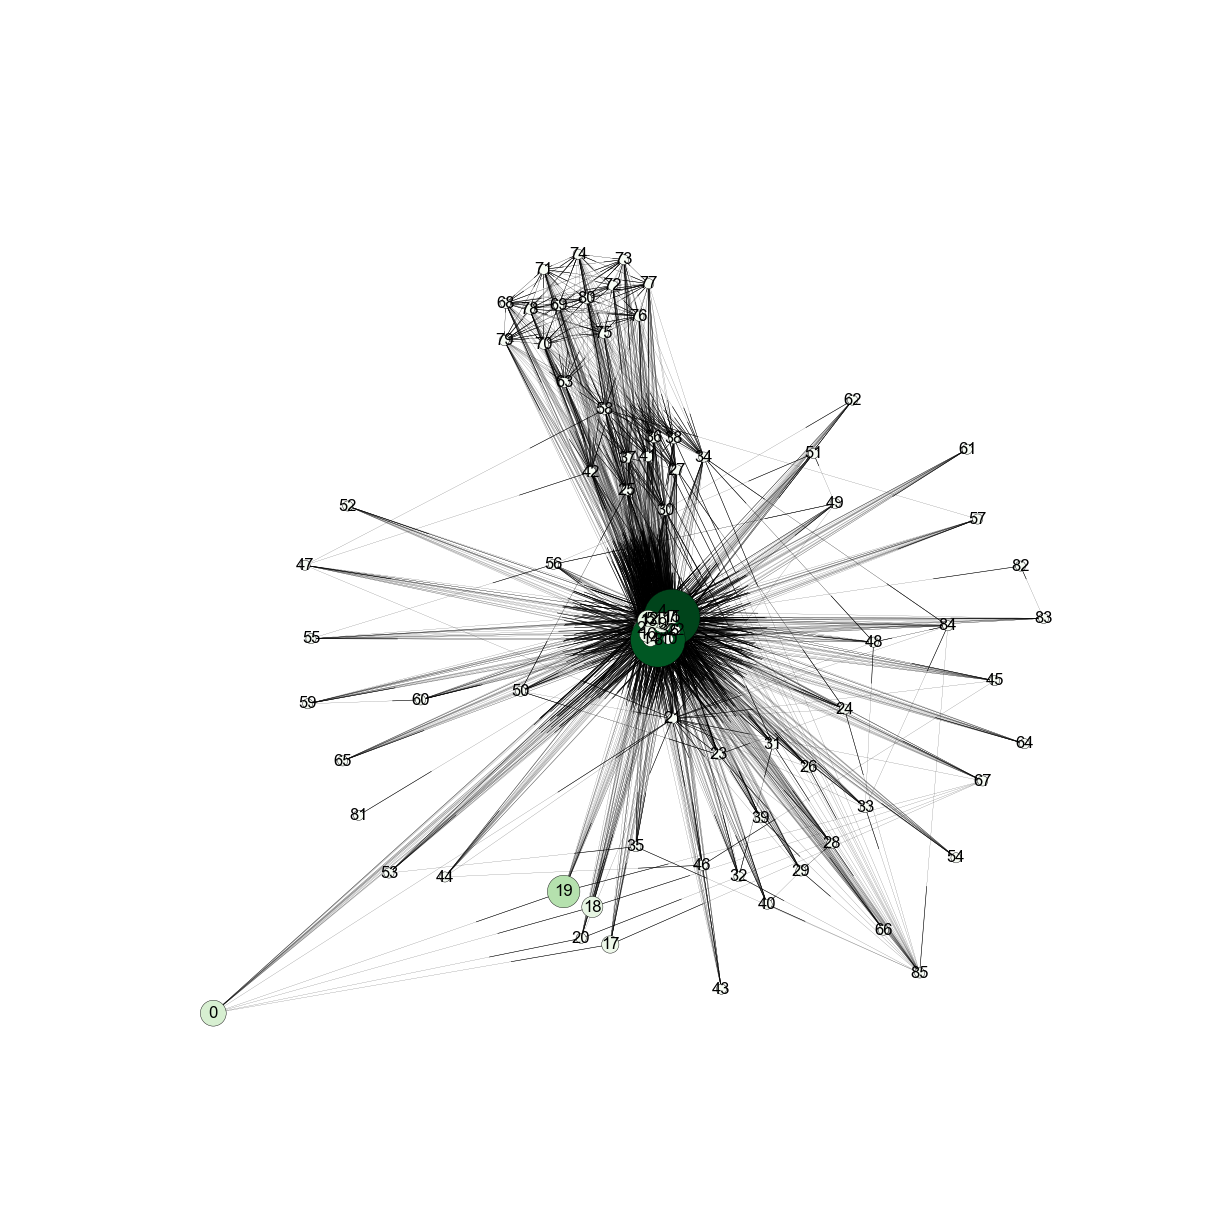

In [33]:
plt.figure(figsize=(15, 15))
start_distribution = np.ones((1, N)) / N
pr_distribution, pr_trace = page_rank(edges, start_distribution, return_trace=True)
size_const = 1e4
plt.axis('off')
networkx.draw_networkx(G, width=0.1, node_size=size_const * pr_distribution, node_color=pr_distribution, cmap='Greens')

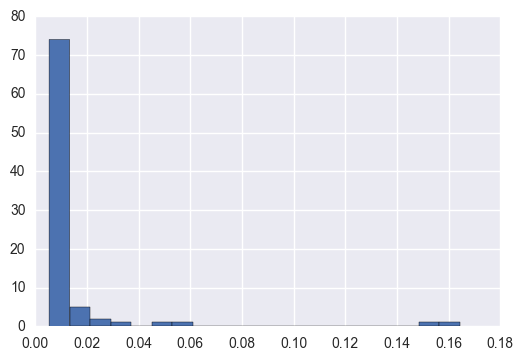

In [25]:
plt.hist(pr_distribution, bins=20)
plt.show()

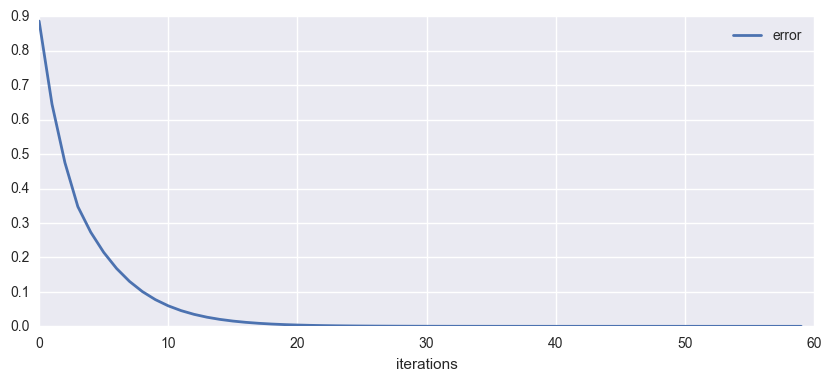

In [27]:
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.legend()
plt.xlabel('iterations')
plt.show()

Скорость сходимости экспоненциальная

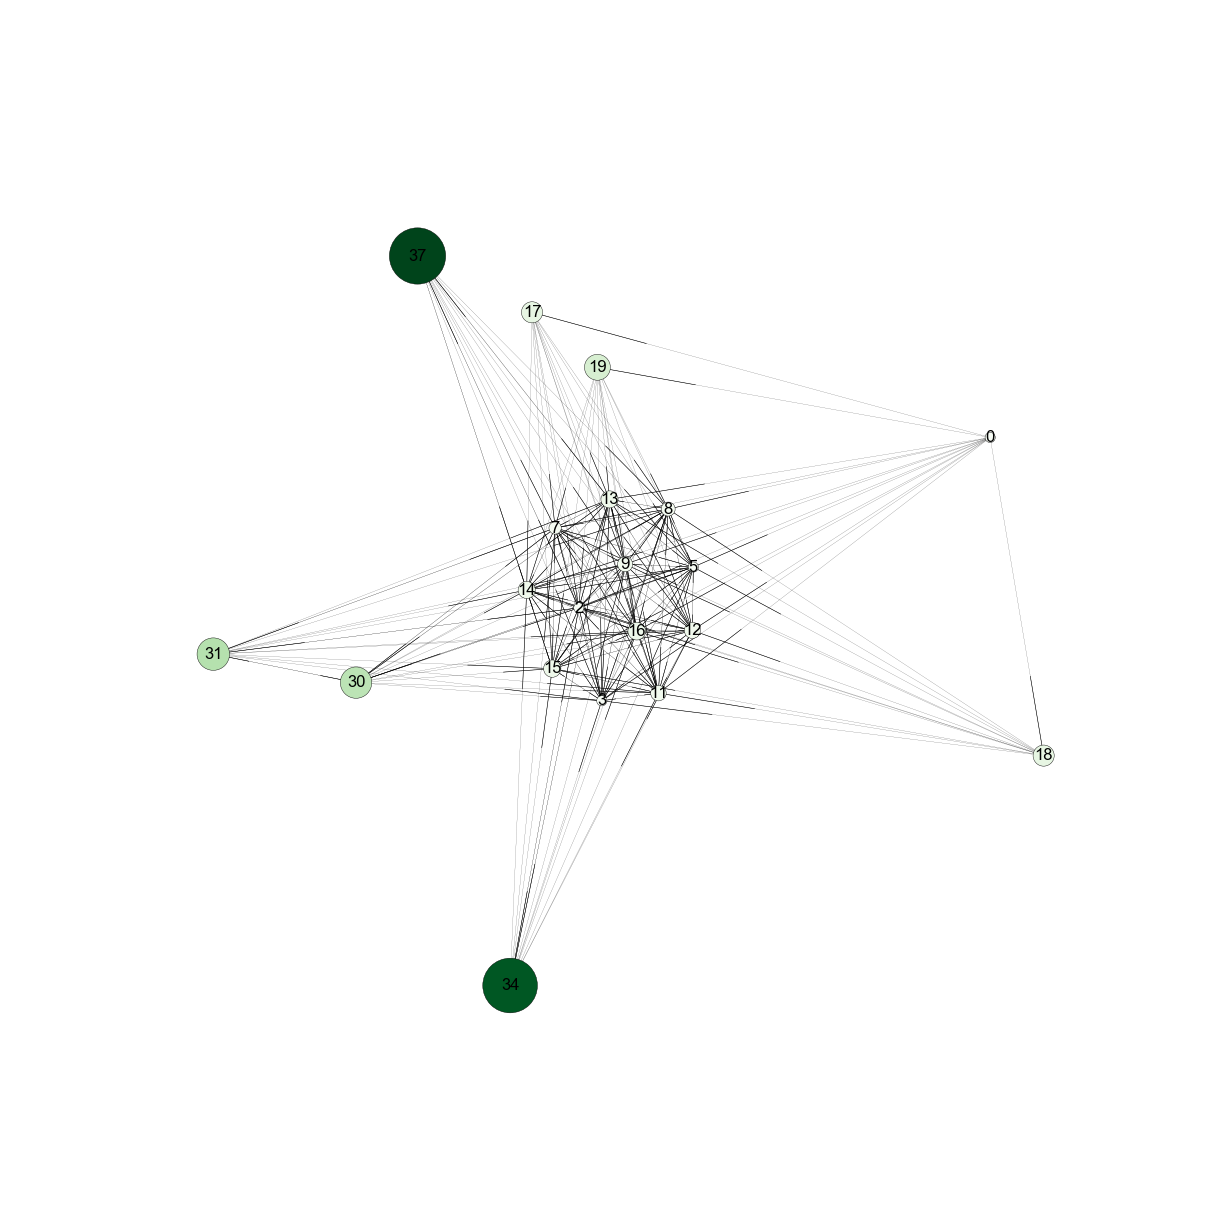

In [53]:
from copy import deepcopy

plt.figure(figsize=(15, 15))
G_small = deepcopy(G)
top = np.argsort(pr_distribution)[-20:]
G_small.remove_nodes_from(set(range(N)) - set(top))
plt.axis('off')
networkx.draw_networkx(G_small, width=0.1, node_size=size_const * pr_distribution[top], node_color=pr_distribution[top], cmap='Greens')

In [59]:
for i in top:
    print("{}: {}".format(i, urls[i]))

31: https://yandexdatafactory.com/solutions/other-solutions/image-classification-and-visual-search/
30: https://yandexdatafactory.com/solutions/other-solutions/custom-search/
34: https://yandexdatafactory.com/solutions/manufacturing-costs-optimisation/
37: https://yandexdatafactory.com/case-studies/federal-road-agency-boosts-patrol-effectiveness-and-cuts-costs-with-ydf-big-data-solution/
12: https://yandexdatafactory.com/company/conference/
15: https://yandexdatafactory.com/company/education/
14: https://yandexdatafactory.com/company/cern/
2: https://yandexdatafactory.com/solutions/custom-machine-learning-solutions/
16: https://yandexdatafactory.com/company/contacts/
9: https://yandexdatafactory.com/company/about/
11: https://yandexdatafactory.com/company/faq/
17: https://yandexdatafactory.com/case-studies/yandex-data-factory-helps-identify-possibly-illicit-loan-providers-online/?utm_source=yandexdatafactory.com&utm_medium=referral&utm_campaign=highlights
5: https://yandexdatafactory.c

Case studies и solutions самые популярные, ведь это первое, что бизнес будет оценивать при использовании YDF.

Заметен также кластер из страниц /company/*

## Часть 3

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [121]:
def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            relevance_and_features, query_id = line.split(' # ')
            split_line = relevance_and_features.split(' ')
            # релевантность и id запроса
            relevs.append(float(split_line[0]))
            qids.append(int(query_id))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[1:]:
                index, value = feat.split(':')
                index = int(index)
                value = float(value)
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)


def write(features, relevs, qids, file_path, index_begin, index_end):
    ''' Создает файл по адресу file_path, в который будут записаны релевантности relevs,
    номера запросов qids и признаки features с номера index_begin по index_end. '''
    
    with open(file_path, 'w') as f:
        for index_line in range(index_begin, index_end):
            f.write('{} qid:{}'.format(relevs[index_line], qids[index_line]))
            for i in range(features.shape[1]):
                f.write(' {}:{}'.format(i + 1, features[index_line, i]))
            f.write('\n')
            

def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)
        
def shuffle(rels, qids, feats):
    d = defaultdict(lambda: ([], []))
    for rel, qid, feat in zip(rels, qids, feats):
        d[qid][0].append(rel)
        d[qid][1].append(feat)
    qids = list(set(qids))
    np.random.shuffle(qids)
    new_rels, new_qids, new_feats = [], [], []
    for qid in qids:
        new_qids.extend([qid] * len(d[qid][0]))
        new_rels.extend(d[qid][0])
        new_feats.extend(d[qid][1])
    return new_rels, new_qids, np.array(new_feats)


def read_new_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[1].split(':')[1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[2:]:
                index, value = map(float, feat.split(':'))
                if index < features_count:
                    object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)

In [107]:
rels, qids, feats = read_file("imat2009-datasets/imat2009_learning.txt", 250)


In [108]:
new_rels, new_qids, new_feats = shuffle(rels, qids, feats)

In [18]:
split_to_train_valid_test(rels, qids, feats,
                          './data/train.txt', './data/test.txt', 0.1, 0.1, 
                          valid_path='./data/valid.txt', valid_size=0.1)

In [44]:
%%time
print("Running LambdaMART_300_5")
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./model/LambdaMART_300_5.txt > ./log/LambdaMART_300_5.txt

Running LambdaMART_300_5
CPU times: user 394 ms, sys: 106 ms, total: 500 ms
Wall time: 34.2 s


In [45]:
%%time
print("Running MART_300_5")
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 0 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./model/MART_300_5.txt > ./log/MART_300_5.txt

Running MART_300_5
CPU times: user 420 ms, sys: 107 ms, total: 527 ms
Wall time: 33.6 s


In [57]:
def read_metric_dependence_from_file(file_name, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        end = text.index("Finished sucessfully.\n", index) - 1
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:end])))
        values.append(block_values)
        text = text[index:]
        
    return values

Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

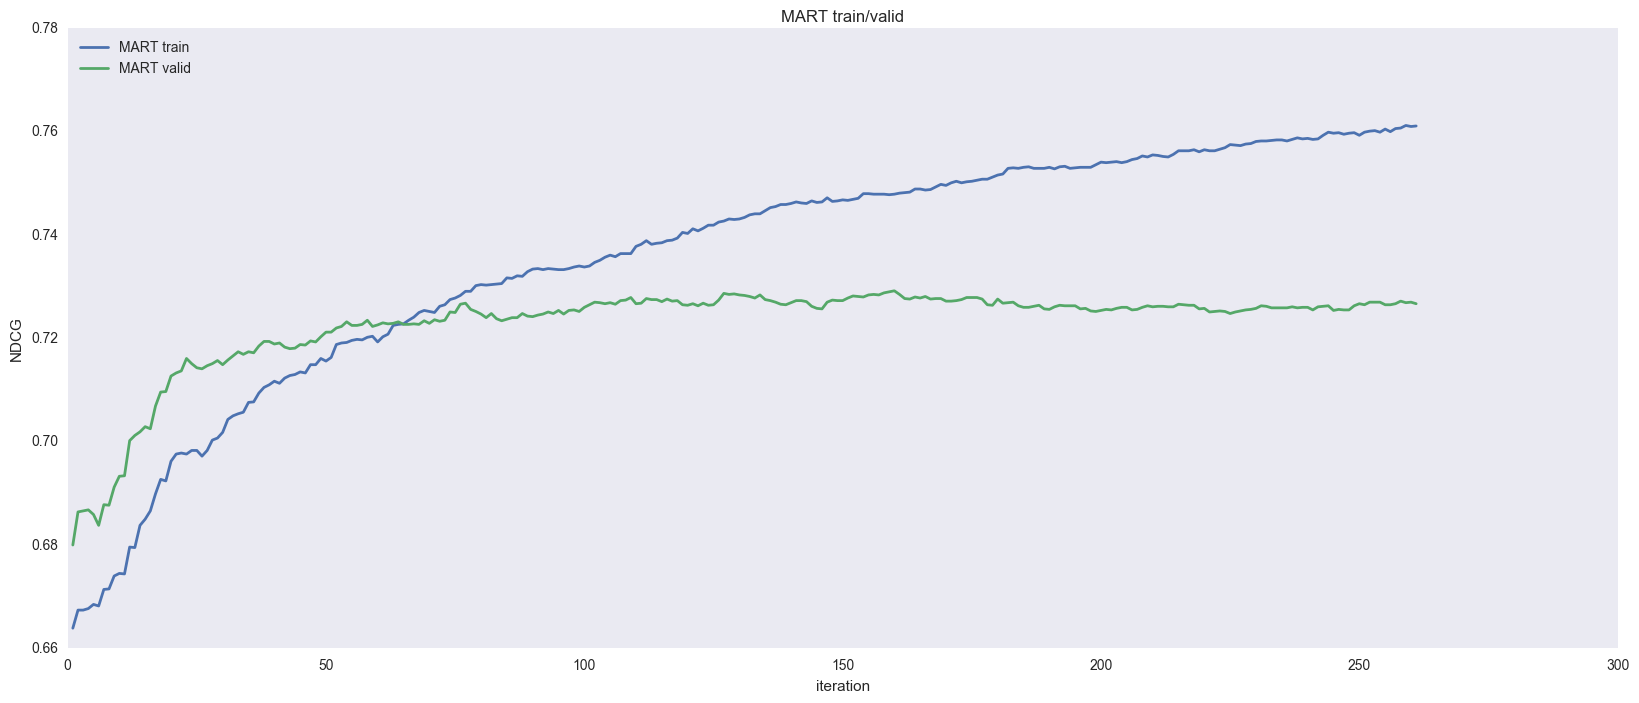

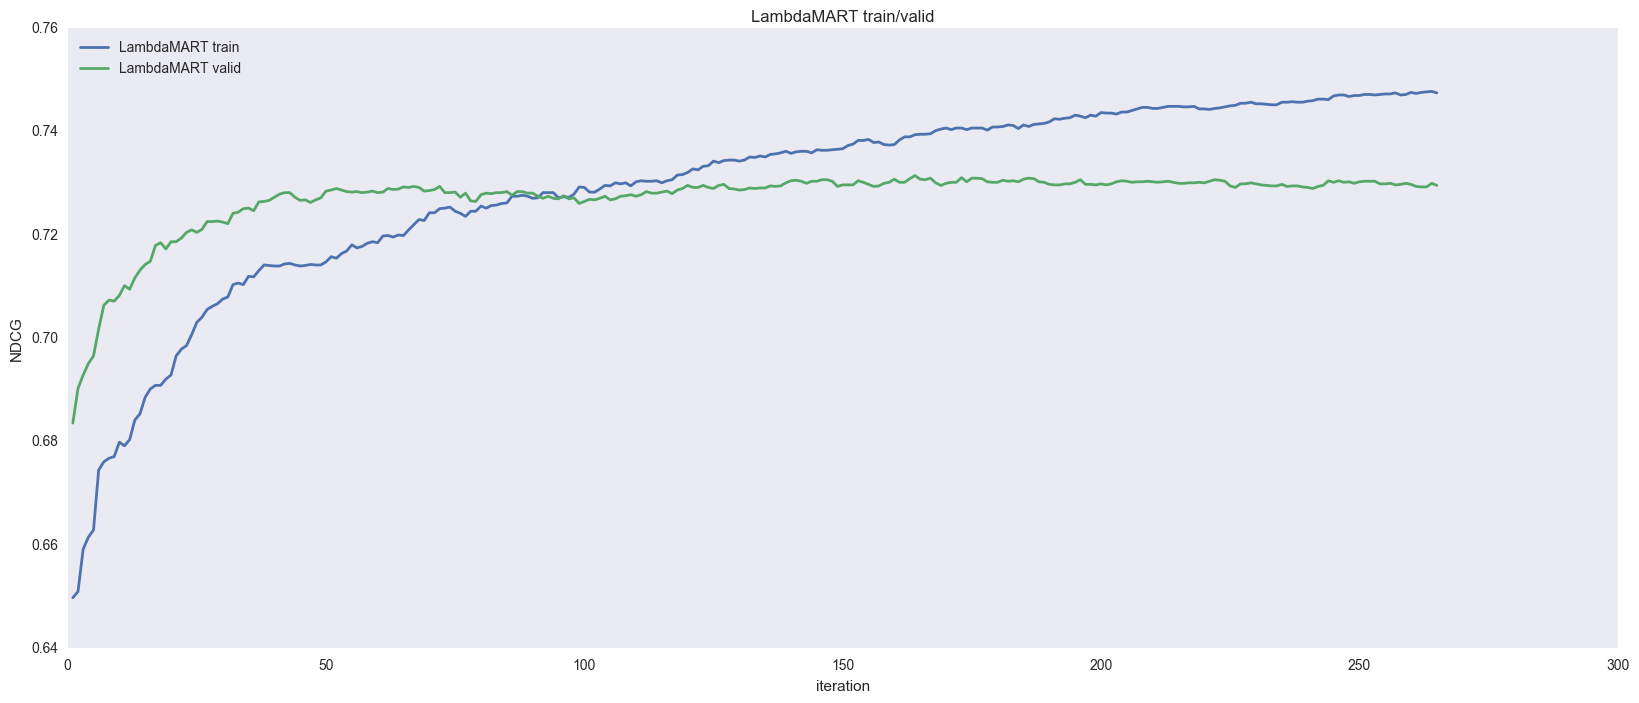

In [86]:
lambda_mart, mart = (read_metric_dependence_from_file("./log/LambdaMART_300_5.txt")[0],
                     read_metric_dependence_from_file("./log/MART_300_5.txt")[0])

plt.figure(figsize=(20, 8))
plt.plot(lambda_mart[:, 0], lambda_mart[:, 1], lw=2, label="MART train")
plt.plot(lambda_mart[:, 0], lambda_mart[:, 2], lw=2, label="MART valid")
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("MART train/valid")
plt.legend(loc=2)
plt.grid()
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(mart[:, 0], mart[:, 1], lw=2, label="LambdaMART train")
plt.plot(mart[:, 0], mart[:, 2], lw=2, label="LambdaMART valid")
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("LambdaMART train/valid")
plt.legend(loc=2)
plt.grid()
plt.show()


Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

Модели работают примерно одинаково, точка переобучения достигается.

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

In [52]:
%%time
print("Running RandomForest_300_100")
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 8 -bag 300 -leaf 100 -metric2t NDCG@10 -save ./model/RandomForest_300_100.txt > ./log/RandomForest_300_100.txt

Running RandomForest_300_100
CPU times: user 2.6 s, sys: 625 ms, total: 3.22 s
Wall time: 3min 29s


In [53]:
%%time
print("Running RankNet_3_30")
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 1 -layer 3 -node 30 -metric2t NDCG@10 -save ./model/RankNet_3_30.txt > ./log/log_RankNet_3_30.txt

Running RankNet_3_30
CPU times: user 7.32 s, sys: 1.78 s, total: 9.1 s
Wall time: 11min 49s


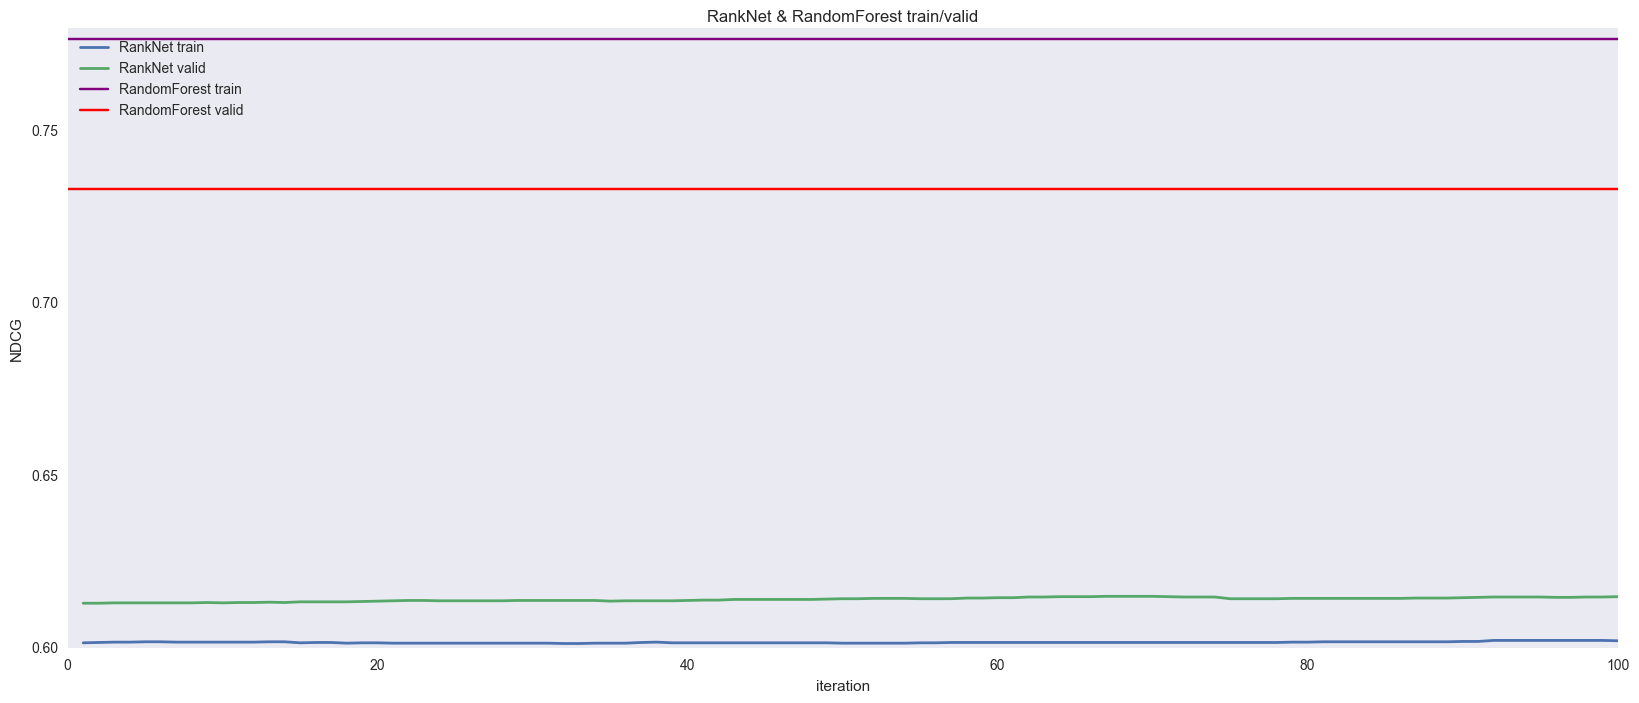

In [88]:
ranknet = np.array(list(read_metric_dependence_from_file("./log/log_RankNet_3_30.txt")[0][1:]))

plt.figure(figsize=(20, 8))
plt.plot(ranknet[:, 0], ranknet[:, -2], lw=2, label="RankNet train")
plt.plot(ranknet[:, 0], ranknet[:, -1], lw=2, label="RankNet valid")
plt.axhline(y=0.7769, color='purple', linestyle='-', label="RandomForest train")
plt.axhline(y=0.7334, color='red', linestyle='-', label="RandomForest valid")
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("RankNet & RandomForest train/valid")
plt.legend(loc=2)
plt.grid()
plt.show()


**Выводы**: нейросетка оказалась хуже, чем RandomForest, MART и LambdaMART

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

Во-первых, мы обучаемся не на всем X_{train}, во-вторых, если алгоритм итеративный, то усреднение нужно знать и по промежуточным итерациям, а не только в конце. Доплнительно из-за early stopping мы можем получить потенциально меньше итераций при разных X_train. Честный алгоритм описан ниже

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

Выполнять консольные команды можно в цикле:

In [111]:
for i in range(5):
    ! echo {np.log(i + 1) ** 2} > file.txt
    with open('file.txt') as f:
        print(f.read())

0.0

0.4804530139182014

1.206948960812582

1.9218120556728056

2.5902903939802346



In [ ]:
M = 10
res = []
for i in range(M):
    rels, qids, feats = shuffle(*read_new_file('./data/train.txt', 250))
    write(feats, rels, qids, './data/train_1.txt', 0, int(len(feats) / 2))
    write(feats, rels, qids, './data/train_2.txt', int(len(feats) / 2), len(feats))
    ! java -jar RankLib-2.1-patched.jar -train ./data/train_1.txt -test ./data/test.txt -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./model/LambdaMART{i}.txt > ./log/LambdaMART{i}.txt
    with open('./model/LambdaMART{}.txt'.format(i)) as model:
        model_text = model.readlines()
        model_header, model_xml = model_text[:7], model_text[7:]
        soup = BeautifulSoup('\n'.join(model_xml), 'lxml')
        tree_tags = soup.find_all('tree')
    k_model_results = []
    ! rm -f './model/LambdaMART_cumulative.txt'; touch './model/LambdaMART_cumulative.txt'
    for k in range(1, 301):
        with open('./model/LambdaMART_cumulative.txt', 'r+') as k_model:
            k_model_text = k_model.readlines()
            k_model_header, k_model_xml = k_model_text[:7], k_model_text[7:]
            if k == 1:
                k_model_header = model_header
                k_model_header[1] = '## No. of trees = {}\n'.format(1)
                k_model_xml = ['<ensemble>\n', str(tree_tags[0]), '</ensemble>\n']
            else:
                model_header[1] = '## No. of trees = {}\n'.format(k)
                k_model_xml.append(str(tree_tags[k-1]))
                ensemble_end = k_model_xml[-2]
                k_model_xml[-2] = k_model_xml[-1]
                k_model_xml[-1] = ensemble_end
        with open('./model/LambdaMART_cumulative.txt', 'w') as k_model:
            k_model.write('\n'.join(k_model_header))
            k_model.write('\n'.join(k_model_xml))
        ! java -jar RankLib-2.1-patched.jar -load ./model/LambdaMART_cumulative.txt -test ./data/test.txt -metric2T NDCG@10 > ./log/result.txt
        with open('./log/result.txt') as res:
            res_text = res.readlines()
            ndcg = float(res_text[-1].split(': ')[1])
            k_model_results.append(ndcg)
    res.append(k_model_results)

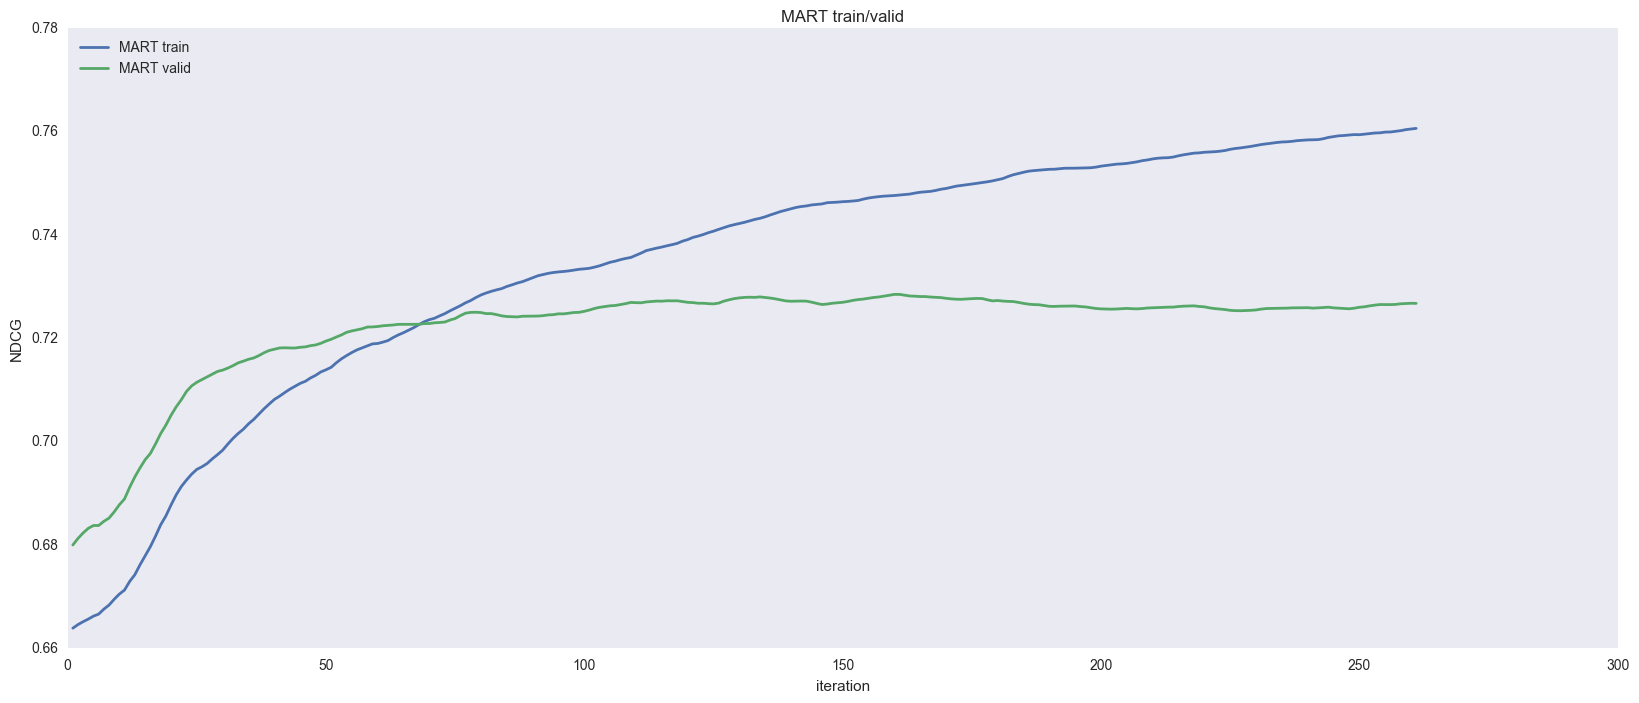

In [123]:
lambda_mart = np.mean(np.array(res), axis=0)

plt.figure(figsize=(20, 8))
plt.plot(lambda_mart[:, 0], lambda_mart[:, 1], lw=2, label="MART train")
plt.plot(lambda_mart[:, 0], lambda_mart[:, 2], lw=2, label="MART valid")
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("MART train/valid")
plt.legend(loc=2)
plt.grid()
plt.show()

